In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [27]:
# whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
#print(torch.cuda.get_device_name(0))

#Checking how many files are in repository for training, testing, and validation
files = glob.glob('600MHz/spectral_data_*.csv')
print('Total number of files: ', len(files))



Using cpu device
Total number of files:  100


In [28]:
class GHzData(Dataset):
    def __init__(self):
        # Data loading starting with list of csv strings
        self.files = glob.glob(os.path.join('600MHz/spectral_data_*.csv'))

        self.y_60 = [] # Establishes a list for 60 MHz data
        self.y_600 = [] # Establishes a list for 600 MHz data

        for self.file in self.files: # For loop for each file in files
            self.df = pd.read_csv(self.file) # Reads each into a pandas dataframe
            self.array_60 = self.df['60MHz_intensity'].to_numpy() # Takes 60MHz intensity to np
            self.array_600 = self.df['600MHz_intensity'].to_numpy() # Takes 400MHz intensity to np
            self.y_60.append(self.array_60) # Appends all arrays to 60MHz list
            self.y_600.append(self.array_600) # Appends all arrays to 400MHz list
            
        # Creates a 60 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_60 = torch.Tensor(self.y_60).float().unsqueeze(1).to(device)        

        # Creates a 400 MHz tensor from list, converts to float, unsqueezes to have shape (n, 1, 5500)
        self.tensor_600 = torch.Tensor(self.y_600).float().unsqueeze(1).to(device)
        
        # Track the length of number of samples in frame
        self.num_samples = len(self.y_60)

    def __getitem__(self, index): # establishes an index for the tensors
        return self.tensor_60[index], self.tensor_600[index]
    
    def __len__(self): # Returns variable number of samples
        return self.num_samples

In [29]:
 #Establishing and loading data into notebook
dataset = GHzData()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(dataset.tensor_60, dataset.tensor_600,
                                                    test_size=0.1)

# Splits train data into validation data
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y,
                                                      test_size=0.1)
# Creating datasets
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)
valid_dataset = TensorDataset(valid_X, valid_y)

# Batch size change to higher batch sizes
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [30]:
# Display  size train_loader
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([8, 1, 5500])
Labels batch shape: torch.Size([8, 1, 5500])


In [76]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(5500, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 5500)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = self.fc5(x)
        return x

In [77]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(5500, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 5500)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = nn.Sigmoid()(self.fc5(x))
        return x


In [103]:
def train_gan(generator, discriminator, train_loader, num_epochs):
    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)
    #total_step = len(data_loader)
    
    #def reset_grad():
    #d_optimizer.zero_grad()
    #g_optimizer.zero_grad()
    
    # define labels for real and fake samples
    real_label = torch.ones([8,5500])
    fake_label = torch.zeros([8,5500])
    
    # create empty lists to store loss values
    d_losses = []
    g_losses = []

    for epoch in range(num_epochs):
        
        for index,(x_real,_) in enumerate(train_dataloader):
            x_real = x_real.view(8,5500).to(device)
            
            
            # train discriminator
            # train discriminator on real samples
            
            d_real = discriminator(x_real)
            loss_d_real = criterion(d_real, real_label)
            real_score = loss_d_real.mean().item()
            
            # generate fake samples
            x_fake = generator(torch.randn(8,x_real.shape[1]).to(device))
            
            # train discriminator on fake samples
            d_fake = discriminator(x_fake.detach())
            loss_d_fake = criterion(d_fake, fake_label)
            fake_score = loss_d_fake.mean().item()
            
            
            # calculate total discriminator loss
            d_loss = loss_d_real + loss_d_fake
            optimizer_d.zero_grad()
            optimizer_g.zero_grad()
            loss_d_fake.backward()
            optimizer_d.step()
            
            # train generator
            # generate samples
            x_fake = generator(torch.randn(8,x_real.shape[1]).to(device))
            
            d_fake = discriminator(x_fake)
            
            loss_g = criterion(d_fake, real_label)
            loss_g.backward()
            optimizer_g.step()
        
            # calculate total generator loss
            g_loss = loss_g
        
            # store loss values
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
        
            # print loss values
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    # plot loss curves
    plt.plot(d_losses, label="Discriminator")
    plt.plot(g_losses, label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.show()


Epoch 1/100, D_loss: 1.3873, G_loss: 0.6956
Epoch 1/100, D_loss: 1.3873, G_loss: 0.6983
Epoch 1/100, D_loss: 1.3869, G_loss: 0.7020
Epoch 1/100, D_loss: 1.3858, G_loss: 0.7068
Epoch 1/100, D_loss: 1.3840, G_loss: 0.7132
Epoch 1/100, D_loss: 1.3810, G_loss: 0.7219
Epoch 1/100, D_loss: 1.3765, G_loss: 0.7332
Epoch 1/100, D_loss: 1.3705, G_loss: 0.7480
Epoch 1/100, D_loss: 1.3629, G_loss: 0.7652
Epoch 1/100, D_loss: 1.3540, G_loss: 0.7844
Epoch 11/100, D_loss: 10.2106, G_loss: 11.7446
Epoch 11/100, D_loss: 12.4012, G_loss: 11.6127
Epoch 11/100, D_loss: 11.3466, G_loss: 11.5118
Epoch 11/100, D_loss: 12.6861, G_loss: 11.2430
Epoch 11/100, D_loss: 9.6802, G_loss: 10.8083
Epoch 11/100, D_loss: 13.0905, G_loss: 10.5957
Epoch 11/100, D_loss: 11.5942, G_loss: 10.0818
Epoch 11/100, D_loss: 12.8289, G_loss: 8.7941
Epoch 11/100, D_loss: 11.6447, G_loss: 8.2674
Epoch 11/100, D_loss: 11.3242, G_loss: 7.8537
Epoch 21/100, D_loss: 15.6755, G_loss: 12.6989
Epoch 21/100, D_loss: 13.9336, G_loss: 11.1270


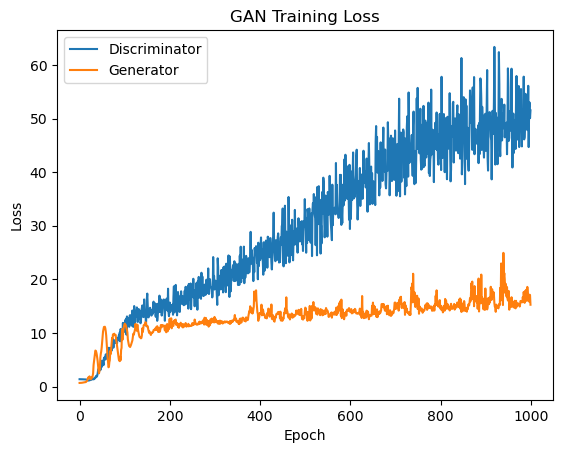

In [104]:

# create generator and discriminator
generator = Generator()

discriminator = Discriminator()

# train GAN
num_epochs = 100
learning_rate=0.001
train_gan(generator, discriminator, train_dataloader, num_epochs)


In [105]:
# generate 600 MHz NMR spectra for input data at 60 MHz
for index,(test_tensor,_) in enumerate(test_dataloader):
    input_data = test_tensor
    output_data = generator(input_data).detach().numpy()
    print(output_data.shape)
    print(input_data.shape)
          

(10, 1, 5500)
torch.Size([10, 1, 5500])


In [ ]:
# plot the first 10 spectra in the output data
plt.figure(figsize=(10, 6))
plt.plot(output_data[0], label=f"Spectrum {i+1}")
plt.legend()
plt.title("Generated 600 MHz NMR Spectra")
plt.xlabel("Data Point")
plt.ylabel("Intensity")
plt.show()